In [1]:
import pandas as pd 
import numpy as np
from math import *

In [2]:
def createDataSet():
    data = pd.read_excel("C:\\Users\\ms\\Desktop\\watermelon.xlsx",sheet_name="Sheet1" )
    # 删除多余没有优化的列
    data = data.drop('编号',axis=1)
    #标签
    labels = list(data.columns)
    #数据集
    dataSet = data.values
    return dataSet, labels

In [3]:
# 测试
# dataSet 中每一列是一个属性
dataSet, labels = createDataSet()
print(dataSet)
print('###############################################################')
print(labels)

[['青绿' '蜷缩' '浊响' '清晰' '凹陷' '硬滑' 0.697 0.46 '是']
 ['乌黑' '蜷缩' '浊闷' '清晰' '凹陷' '硬滑' 0.774 0.376 '是']
 ['乌黑' '蜷缩' '浊响' '清晰' '凹陷' '硬滑' 0.634 0.264 '是']
 ['青绿' '蜷缩' '浊闷' '清晰' '凹陷' '硬滑' 0.608 0.318 '是']
 ['浅白' '蜷缩' '浊响' '清晰' '凹陷' '硬滑' 0.556 0.215 '是']
 ['青绿' '稍蜷' '浊响' '清晰' '稍凹' '软粘' 0.403 0.237 '是']
 ['乌黑' '稍蜷' '浊响' '稍糊' '稍凹' '软粘' 0.481 0.149 '是']
 ['乌黑' '稍蜷' '浊响' '清晰' '稍凹' '硬滑' 0.437 0.211 '是']
 ['乌黑' '稍蜷' '浊闷' '稍糊' '稍凹' '硬滑' 0.666 0.091 '否']
 ['青绿' '硬挺' '清脆' '清晰' '平坦' '软粘' 0.243 0.267 '否']
 ['浅白' '硬挺' '清脆' '模糊' '平坦' '硬滑' 0.245 0.057 '否']
 ['浅白' '蜷缩' '浊响' '模糊' '平坦' '软粘' 0.343 0.099 '否']
 ['青绿' '稍蜷' '浊响' '稍糊' '凹陷' '硬滑' 0.639 0.161 '否']
 ['浅白' '稍蜷' '沉闷' '稍糊' '凹陷' '硬滑' 0.657 0.198 '否']
 ['乌黑' '稍蜷' '浊响' '清晰' '稍凹' '软粘' 0.36 0.37 '否']
 ['浅白' '蜷缩' '浊响' '模糊' '平坦' '硬滑' 0.593 0.042 '否']
 ['青绿' '蜷缩' '沉闷' '稍糊' '稍凹' '硬滑' 0.719 0.103 '否']]
###############################################################
['色泽', '根蒂', '敲声', '纹理', '脐部', '触感', '密度', '含糖率', '好瓜']


##  计算信息熵

In [4]:
def calcInfoEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}    # 给所有可能的分类创建字典
    for featVec in dataSet:    # 循环遍历行
        currentLabel = featVec[-1]    # 每行的最后一个元素
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0 # 如果当前label不在字典中赋值0创建 
        labelCounts[currentLabel] += 1 # 统计label个数，此行不受if语句影响；当前加else时，受if影响，上一句labelCounts应赋值1
    InfoEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        # 以2为底计算信息熵，ID3用的信息增益公式。
        InfoEnt -= prob * log(prob,2)
    return InfoEnt

In [5]:
# 测试 
calcInfoEnt(dataSet)

0.9975025463691153

## 根据特征分割数据集

####   1、对离散变量划分数据集，取出该特征取值为value的所有样本  

In [6]:
def splitDiscreteDataSet(dataSet,axis,value):
    """
    :param dataSet: 当前结点(待划分)集合
    :param axis:划分数据集的特征的维度
    :param value:特征的值
    :return: 符合该特征的所有实例（并且自动移除掉这维特征）
    """
    # 循环遍历dataSet中的每一行数据
    retDataSet = []
    for featVec in dataSet:
        # 判断axis列的值
        if featVec[axis] == value:
            reduceFeatVec = list(featVec[:axis]) # 删除这一维值为value的特征
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec) 
            # 此处得到的子集特征数比划分前少1，少了那个用来划分的数据
    return retDataSet

In [7]:
# 测试一个离散属性

# 返回第1列色泽为青绿的所有集合
splitDiscreteDataSet(dataSet,0,'青绿')

[['蜷缩', '浊响', '清晰', '凹陷', '硬滑', 0.697, 0.46, '是'],
 ['蜷缩', '浊闷', '清晰', '凹陷', '硬滑', 0.608, 0.318, '是'],
 ['稍蜷', '浊响', '清晰', '稍凹', '软粘', 0.403, 0.237, '是'],
 ['硬挺', '清脆', '清晰', '平坦', '软粘', 0.243, 0.267, '否'],
 ['稍蜷', '浊响', '稍糊', '凹陷', '硬滑', 0.639, 0.161, '否'],
 ['蜷缩', '沉闷', '稍糊', '稍凹', '硬滑', 0.719, 0.103, '否']]

####  2、 对连续变量划分数据集  

In [8]:
# 方案一

# 按照给定的value，在给定的维度axis上划分为两个数据集
def splitContinuousDataSet(dataSet, axis, value): 
    retDataSetG=[] #将储存取值大于value的样本
    retDataSetL=[] #将储存取值小于value的样本  
    for featVec in dataSet:  
        if featVec[axis]>value:  
            reducedFeatVecG=list(featVec[:axis])
            reducedFeatVecG.extend(featVec[axis+1:])  
            retDataSetG.append(reducedFeatVecG)
        else:
            reducedFeatVecL=list(featVec[:axis])
            reducedFeatVecL.extend(featVec[axis+1:])  
            retDataSetL.append(reducedFeatVecL)
    return retDataSetG,retDataSetL #返回两个集合

In [9]:
# 测试连续属性
a=splitContinuousDataSet(dataSet,6,0.5)
a[0]

[['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 0.46, '是'],
 ['乌黑', '蜷缩', '浊闷', '清晰', '凹陷', '硬滑', 0.376, '是'],
 ['乌黑', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 0.264, '是'],
 ['青绿', '蜷缩', '浊闷', '清晰', '凹陷', '硬滑', 0.318, '是'],
 ['浅白', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', 0.215, '是'],
 ['乌黑', '稍蜷', '浊闷', '稍糊', '稍凹', '硬滑', 0.091, '否'],
 ['青绿', '稍蜷', '浊响', '稍糊', '凹陷', '硬滑', 0.161, '否'],
 ['浅白', '稍蜷', '沉闷', '稍糊', '凹陷', '硬滑', 0.198, '否'],
 ['浅白', '蜷缩', '浊响', '模糊', '平坦', '硬滑', 0.042, '否'],
 ['青绿', '蜷缩', '沉闷', '稍糊', '稍凹', '硬滑', 0.103, '否']]

In [10]:
# 方案二

# 按照指定的方向划分数据集
def splitContinuousDataSet2(dataSet, axis, value, direction): 
    '''
    direction规定划分的方向
    '''
    retDataSet = []  
    for featVec in dataSet:  
        if direction == 0:  
            if featVec[axis] > value:  
                retDataSet.append(list(featVec[:axis]) + list(featVec[axis + 1:]))  
        else:  
            if featVec[axis] <= value:  
                retDataSet.append(list(featVec[:axis]) + list(featVec[axis + 1:]))  
    return retDataSet  


In [11]:
splitContinuousDataSet2(dataSet,6,0.5,1)

[['青绿', '稍蜷', '浊响', '清晰', '稍凹', '软粘', 0.237, '是'],
 ['乌黑', '稍蜷', '浊响', '稍糊', '稍凹', '软粘', 0.149, '是'],
 ['乌黑', '稍蜷', '浊响', '清晰', '稍凹', '硬滑', 0.211, '是'],
 ['青绿', '硬挺', '清脆', '清晰', '平坦', '软粘', 0.267, '否'],
 ['浅白', '硬挺', '清脆', '模糊', '平坦', '硬滑', 0.057, '否'],
 ['浅白', '蜷缩', '浊响', '模糊', '平坦', '软粘', 0.099, '否'],
 ['乌黑', '稍蜷', '浊响', '清晰', '稍凹', '软粘', 0.37, '否']]

#### 3、根据InfoGain选择当前最好的划分特征(以及对于连续变量还要选择以什么值划分)

In [12]:
def chooseBestFeatureToSplit(dataSet,labels):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcInfoEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    bestSplitDict = {}
    for i in range(numFeatures):
        # 取dataSet数据中每一行的第i个feature值
        featList = [example[i] for example in dataSet]
        # 判断是否为离散属性
        if not (type(featList[0]).__name__ == 'float' or type(featList[0]).__name__ == 'int'):
            # 当为离散属性时：
            uniqueVals = set(featList)
            newEntropy = 0.0
            for value in uniqueVals:
                subDataSet = splitDiscreteDataSet(dataSet,i,value)
                prob = len(subDataSet) / float(len(dataSet))
                newEntropy += prob * calcInfoEnt(subDataSet) # 各取值的熵累加
            infoGain = baseEntropy - newEntropy # 得到以该特征划分的信息增益
        else:
            # 连续属性时：
            
            sortfeatList = sorted(featList)   # 把连续数据从小到大排序
            splitList = []
            # 产生n-1个候选划分点
            for j in range(len(sortfeatList) - 1):
                splitList.append((sortfeatList[j] + sortfeatList[j+1]) / 2.0)
            # 设定一个很大的熵值（之后用）
            bestSplitEntropy = 10000
            # 遍历n-1个候选划分点：求选第j个候选划分点划分时的熵值，并选出最佳划分点
            for j in range(len(splitList)):
                value = splitList[j]
                newEntropy = 0.0
                DataSet = splitContinuousDataSet(dataSet,i,value)
                subDataSetG = DataSet[0]
                subDataSetL = DataSet[1]
                
                
                probG = len(subDataSetG) / float(len(dataSet))
                newEntropy += probG * calcInfoEnt(subDataSetG)
                
                probL = len(subDataSetL) / float(len(dataSet))
                newEntropy += probL * calcInfoEnt(subDataSetL)
                
                #newEntropy = newEntropyG + newEntropyL
                
                if newEntropy <  bestSplitEntropy:                  
                    bestSplitEntropy = newEntropy
                    bestSplit = j
            bestSplitDict[labels[i]] = splitList[bestSplit] #字典记录当前连续属性的最佳划分点
            # 计算该结点划分的熵增
            infoGain = baseEntropy - bestSplitEntropy
        
        # 在所有属性（包括连续和离散）中选择可以获得最大熵的属性
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
        
        # 若当前节点的最佳划分特征为连续特征，则需根据“是否小于等于其最佳划分点”进行二值化处理
            #即将该特征改为“是否小于等于bestSplitValue”, 例如将“密度”变为“密度<=0.3815”
    if type(dataSet[0][bestFeature]).__name__ == 'float' or type(dataSet[0][bestFeature]).__name__ == 'int' :
        bestSplitValue = bestSplitDict[labels[bestFeature]]
        labels[bestFeature] = labels[bestFeature] + '<=' + str(bestSplitValue)
            
        # 遍历dataset数据集的行
        #注意：以下这段直接操作了原dataSet数据, 之前的那些float型的值相应变为0和1
          #【为何这样做?】在函数createTree()末尾将看到解释
        for i in range(np.array(dataSet).shape[0]):
            if dataSet[i][bestFeature] <= bestSplitValue:
                dataSet[i][bestFeature] = 1
            else:
                dataSet[i][bestFeature] = 0
    return bestFeature
                
            
            

In [13]:
# 测试 
chooseBestFeatureToSplit(dataSet,labels)

3

#### 投票计数选择

In [14]:
import operator
def majorityCnt(classList):
    """
    这个函数的作用是返回字典中出现次数最多的value对应的key，也就是输入list中出现最多的那个值
    return: 类别列表中多数的类，即多数表决
    """
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): 
            classCount[vote] = 0
        classCount[vote] += 1
    # 字典按照value排序 
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
 
    return sortedClassCount[0][0]   # 返回字典第一项的key值


## 主程序：递归产生决策树

In [15]:

def createTree(dataSet,labels,data_full,labels_full):
    '''
    # dataSet：当前用于构建树的数据集, 最开始就是data_full，然后随着划分的进行越来越小。
    # 这是因为进行到到树分叉点上了. 第一次划分之前17个瓜的数据在根节点，然后选择第一个bestFeat是纹理. 
    纹理的取值有清晰、模糊、稍糊三种；将瓜分成了清晰（9个），稍糊（5个），模糊（3个）,这时应该将划分的类别减少1以便于下次划分。 
    # labels：当前数据集中有的用于划分的类别(这是因为有些Label当前数据集没了, 比如假如到某个点上西瓜都是浅白没有深绿了)
    # data_full：全部的数据 
    # label_full:全部的类别 

    '''
    classList=[example[-1] for example in dataSet] 
    
    #递归停止条件1：当前节点所有样本属于同一类；(注：count()方法统计某元素在列表中出现的次数)
    if classList.count(classList[0])==len(classList):  
        return classList[0]  
    #递归停止条件2：所有可用于划分的特征均使用过了，则调用majorityCnt()投票定Label；
    if len(dataSet[0])==1:  
        return majorityCnt(classList) 
    #递归停止条件3：当前节点上样本集合为空集(即特征的某个取值上已经没有样本了)
    if float(np.array(dataSet).shape[0])==0:  
        return 'empty'
    
    #调用函数找出当前最佳划分特征是第几个
    bestFeat=chooseBestFeatureToSplit(dataSet,labels)  
    bestFeatLabel=labels[bestFeat]    #当前最佳划分特征
    
    # map 结构，且key为featureLabel
    myTree={bestFeatLabel:{}}  
    featValues=[example[bestFeat] for example in dataSet]  
    uniqueVals=set(featValues)  
    if type(dataSet[0][bestFeat]).__name__=='str':  
        currentlabel=labels_full.index(labels[bestFeat])  
        featValuesFull=[example[currentlabel] for example in data_full]  
        uniqueValsFull=set(featValuesFull)  
    #划分完后, 即当前特征已经使用过了, 故将其从“待划分特征集”中删去
    del(labels[bestFeat])  
    # 递归调用，针对当前划分的bestFeat的每个取值，划分出一个子树。  
    for value in uniqueVals:  #遍历该特征【现存的】取值
        subLabels=labels[:]  
        if type(dataSet[0][bestFeat]).__name__=='str':  
            uniqueValsFull.remove(value)   #划分后删去(从uniqueValsFull中删!)
        myTree[bestFeatLabel][value]=createTree(splitDiscreteDataSet(dataSet,bestFeat,value),subLabels,data_full,labels_full)  
    # 若该特征为离散
    if type(dataSet[0][bestFeat]).__name__=='str':  
        for value in uniqueValsFull: 
            #则可能有些取值已经不在【现存的】取值中了
            #这就是上面为何从“uniqueValsFull”中删去
            #因为那些现有数据集中没取到的该特征的值，保留在了其中
            myTree[bestFeatLabel][value]=majorityCnt(classList)  
    return myTree  


### 获得数据集

In [16]:
df = pd.read_excel("C:\\Users\\ms\\Desktop\\watermelon.xlsx",sheet_name="Sheet1" )
# 删除多余没有优化的列
df = df.drop('编号',axis=1)
#标签
labels = list(df.columns)
#数据集
data = df.values

labels_full=labels.copy()
data_full=data.copy()

In [18]:
myTree=createTree(data,labels,data_full,labels_full)
myTree

{'纹理': {'模糊': '否',
  '清晰': {'密度<=0.3815': {0: '是', 1: '否'}},
  '稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}}}

In [19]:
import matplotlib.pyplot as plt

'''
绘制决策树的函数
'''

# 定义文本框和箭头格式
decisionNode = dict(boxstyle="round4", color='#3366FF')  #定义判断结点形态
leafNode = dict(boxstyle="circle", color='#FF6633')  #定义叶结点形态
arrow_args = dict(arrowstyle="<-", color='g')  #定义箭头

#绘制带箭头的注释
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)


#计算叶结点数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]    # 'dict_keys' object does not support indexing
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        #测试节点的数据是否为字典，以此判断是否为叶节点
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


#计算树的最大深度(层数)
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]   # 'dict_keys' object does not support indexing
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        #测试节点的数据是否为字典，以此判断是否为叶节点
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth


#在父子结点间填充文本信息
#标签头上的文字
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)


def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)  #在父子结点间填充文本信息
    plotNode(firstStr, cntrPt, parentPt, decisionNode)  #绘制带箭头的注释
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD


def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW;
    plotTree.yOff = 1.0;
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

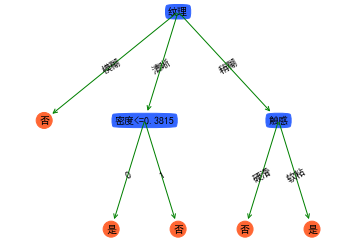

In [20]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题
##################################

# 绘制ID3决策树
createPlot(myTree)